In [6]:
import numpy as np
import bayes3d as b
from tqdm import tqdm
import jax
import jax.numpy as jnp
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
import matplotlib.pyplot as plt
def projection(x=0.1, n=1.0, f=50.0):
    return np.array([[n/x,    0,            0,              0],
                     [  0,  n/x,            0,              0],
                     [  0,    0, -(f+n)/(f-n), -(2*f*n)/(f-n)],
                     [  0,    0,           -1,              0]]).astype(np.float32)
def translate(x, y, z):
    return np.array([[1, 0, 0, x],
                     [0, 1, 0, y],
                     [0, 0, 1, z],
                     [0, 0, 0, 1]]).astype(np.float32)

mvp = np.matmul(projection(x=0.4), translate(0, 0, 0.0)).astype(np.float32)
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.01, far=5.5
)
jax_renderer = JaxRenderer(intrinsics)

import os
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

vertices = jnp.array(m.vertices.astype(np.float32))
face_indices = jnp.array(m.faces.astype(np.int32))
vertices_homogenous = b.add_homogenous_ones(vertices)

New Plugin


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7032/static/


In [37]:
# pose = b.transform_from_pos(jnp.array([0.0, 0.0, -3.5])) @ b.distributions.vmf(jax.random.PRNGKey(10), 0.01)
# vertices_pose_transformed = vertices_homogenous @ pose.T
# vertices_projected = vertices_pose_transformed @ mvp.T
# rast_out, rast_out_db = jax_renderer.rasterize(vertices_projected[None,...], face_indices, jnp.array([intrinsics.height, intrinsics.width]))
# colors,_ = jax_renderer.interpolate(vertices_pose_transformed[:,2:3][None,...], rast_out, face_indices, rast_out_db, jnp.array([0]))
key = jax.random.PRNGKey(15)

def render_img(pos,quat):
    pose = b.transform_from_rot_and_pos(b.quaternion_to_rotation_matrix(quat), pos)
    vertices_pose_transformed = vertices_homogenous @ pose.T
    vertices_projected = vertices_pose_transformed @ mvp.T
    rast_out, rast_out_db = jax_renderer.rasterize(vertices_projected[None,...], face_indices, jnp.array([intrinsics.height, intrinsics.width]))
    colors_gt,_ = jax_renderer.interpolate(vertices_pose_transformed[:,2:3][None,...], rast_out, face_indices, rast_out_db, jnp.array([0]))
    return colors_gt

def loss(pos, quat, colors_gt):
    colors = render_img(pos,quat)
    return jnp.mean(jnp.abs(colors_gt - colors))

grad_func = jax.jit(jax.value_and_grad(loss, argnums=(0,1)))


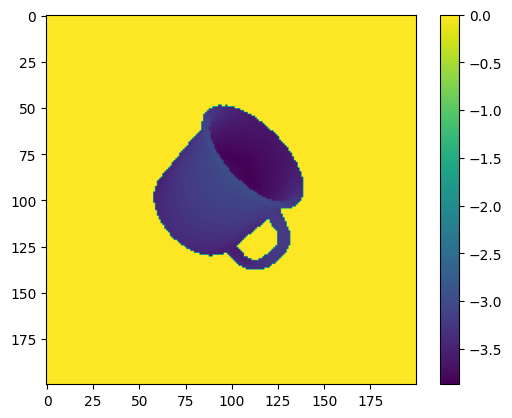

In [39]:
key = jax.random.split(key, 2)[0]
pos, quat = jnp.array([0.0, 0.0, -3.5]), jax.random.uniform(key, shape=(4,))
colors_gt = render_img(pos,quat)
plt.imshow(colors_gt[0,...,0])
plt.colorbar()

In [41]:

grad_func(pos, quat, colors_gt)

(Array(0.37842774, dtype=float32),
 (Array([ 0.01494987, -0.04079978, -0.02720834], dtype=float32),
  Array([ 0.00034882,  0.00080669, -0.00049675, -0.00123283], dtype=float32)))

0.1714843511581421:   0%|          | 0/1000 [00:00<?, ?it/s] 

0.17066088318824768: 100%|██████████| 1000/1000 [00:02<00:00, 434.35it/s]


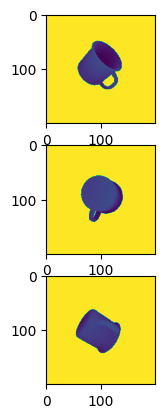

In [44]:
key = jax.random.split(key, 2)[0]
pos, quat = jnp.array([0.0, 0.0, -3.4]), jax.random.uniform(key, shape=(4,))
begining_img = render_img(pos,quat)
pbar = tqdm(range(1000))
for _ in pbar:
    loss, (pos_grad, quat_grad) = grad_func(pos, quat, colors_gt)
    pbar.set_description(f"{loss.item()}")
    pos = pos - 0.001 * pos_grad
    quat = quat - 0.5 * quat_grad

img = render_img(pos,quat)
fig,ax = plt.subplots(3)
ax[0].imshow(colors_gt[0,...,0])
ax[1].imshow(begining_img[0,...,0])
ax[2].imshow(img[0,...,0])

0.037829828
0.030563647
0.038017545
0.030542407
0.03744647
0.030187067
0.037729163
0.030302124
0.037652045
0.030397167
0.037627585
0.03036035
0.038222887
0.031187942
0.03788771
0.030461505
0.03724308
0.03047015
0.039671768
0.032175615
0.037150376
0.030647768
0.037544373
0.030386358
0.03744043
0.030311255
0.03812728
0.031268034
0.03665354
0.030206366
0.037188012
0.030425912
0.037233528
0.030480096
0.03811159
0.031454258
0.03700574
0.030030727
0.037171923
0.030282341
0.03773543
0.030551257
0.036923602
0.030397583
0.03702419
0.030344311
0.03690779
0.029800167
0.03736253
0.02983684
0.037474684
0.030625463
0.035881944
0.029824508
0.037729096
0.030880693
0.03649851
0.03019726
0.037394408
0.030507872
0.036994033
0.030322604
0.037391376
0.030794714
0.03664673
0.030286193
0.037006248
0.030405346
0.03728631
0.0305401
0.036377203
0.030151995
0.0372891
0.030354671
0.036541883
0.029767541
0.037076954
0.030271819
0.036853872
0.030248236
0.03690084
0.029466577
0.036810756
0.030374419
0.03686748
0.030

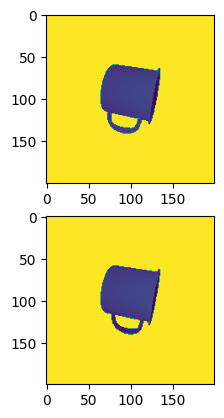

In [122]:
img = render_img(pos,quat)
fig,ax = plt.subplots(2)
ax[0].imshow(img[0,...,0])
ax[1].imshow(colors_gt[0,...,0])

In [37]:
point_cloud = b.unproject_depth_jit(-colors[0,...,0], intrinsics).reshape(-1,3)
b.show_cloud("1", point_cloud, color=b.BLACK)

In [25]:
b.show_cloud("1", vertices_pose_transformed, color=b.BLACK)

In [19]:
vertices_pose_transformed

Array([[-0.42476   , -0.258425  , -2.84767   ,  1.        ],
       [-0.43339002, -0.250045  , -2.8395    ,  1.        ],
       [-0.4441    , -0.233835  , -2.85271   ,  1.        ],
       ...,
       [ 0.49043998, -0.014525  , -2.27438   ,  1.        ],
       [ 0.30558002, -0.051185  , -2.2418299 ,  1.        ],
       [ 0.34171   , -0.048345  , -2.11763   ,  1.        ]],      dtype=float32)

In [ ]:




def render(glctx, mtx, pos, pos_idx, resolution: int):
    # Setup TF graph for reference.
    depth_ = pos[..., 2:3]
    depth = torch.tensor([[[(z_val/1)] for z_val in depth_.squeeze()]], dtype=torch.float32).cuda()
    pos_clip    = transform_pos(mtx, pos)
    rast_out, _ = dr.rasterize(glctx, pos_clip, pos_idx, resolution=[resolution, resolution])
    color   , _ = dr.interpolate(depth, rast_out, pos_idx)
    # color       = dr.antialias(color, rast_out, pos_clip, pos_idx)
    return color